#### 1. Setup

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # K-means clustering

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [2]:
# if GPU is available, then use
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
data_dir = "../datasets/cityscapes_data"

train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


#### 2. Analyze

../datasets/cityscapes_data/train/973.jpg


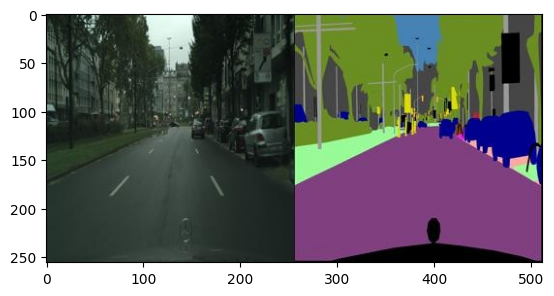

In [4]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [5]:
def split_image(image):
    image = np.array(image) # NumPy array (Height, Width, Channels)
    # Resizing
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
0 255 0 255


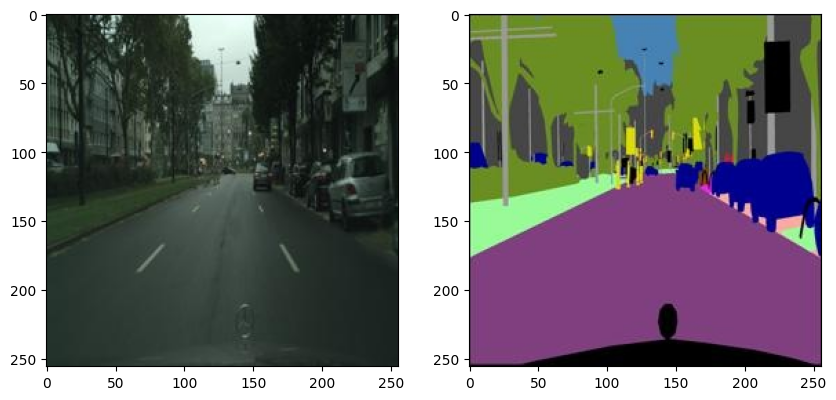

In [6]:
sample_image = np.array(sample_image)
print(sample_image.shape) # output: (H, W, C)

cityscape, label = split_image(sample_image)
# cityscape.shape==(H, W/2, C), label.shape==(H, W/2, C)
print(cityscape.min(), cityscape.max(), label.min(), label.max())

# NumPy array -> PIL image
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)

# present image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

#### 3. Define Labels

In [7]:
# Output Label
num_items = 1000

# randomly choose a number between 0 and 255, 1000 times
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape) # (1000, 3): RGB 3-chanels vector x 1000
print(color_array[:5, :]) # RGB of 5 samples

(1000, 3)
[[ 35 119 243]
 [149 122 185]
 [229 229 118]
 [165  66 177]
 [127  61  96]]


In [8]:
num_classes = 10

# store in label_model by K-means clustering
label_model = KMeans(n_clusters=num_classes, n_init='auto')
label_model.fit(color_array) # train Model

KMeans(n_clusters=10, n_init='auto')

In [9]:
label_model.predict(color_array[:5, :]) # predict clustering index(0~9) of 5 samples

array([7, 1, 4, 6, 1], dtype=int32)

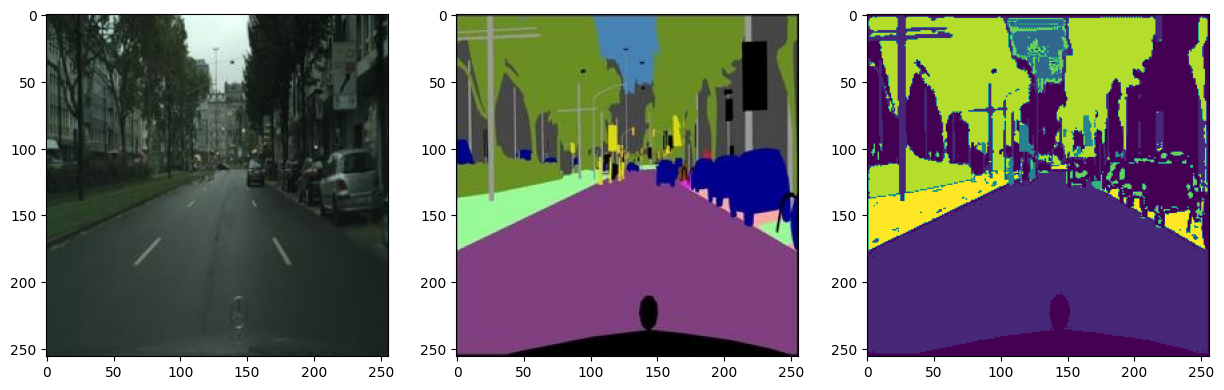

In [10]:
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class) # result of K-means clustering

In [11]:
label_class

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 1, 0],
       ...,
       [0, 0, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

#### 4. Define Dataset